In [3]:
import numpy as np
import pandas as pd
import os
import glob
from stat_analysis import *
from analysis_helper import *
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
setup_scmamp_rpy2()

iter_max=50
task_col='pcba-aid624173'
cluster_col='BT_0.4 ID'

run_threshold=9
hs_params, benchmark_params, custom_params = 12, 7, 3
hs_job_count = hs_params*10
benchmark_job_count = benchmark_params*10
custom_job_count = custom_params*10

root_dir = '../../../aldd_results/aldd_exp_2_final\\'
hs_dir = glob.glob(root_dir+'sampled_hyparams/*/*/*/')
custom_dir = glob.glob(root_dir+'custom_cbws/*/*/*/')
benchmark_dir = glob.glob(root_dir+'benchmarks/*/*/*/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
all_96_hs, _, _, all_df_hs, successful_jobs, failed_jobs = get_results(hs_dir, iter_max, task_col, cluster_col, run_threshold, 
                                                                       check_failure=True, drop_runs=False)

print('----------------------------------------------------------------------------')
print('HS Jobs:')
print('Total jobs: {}'.format(hs_job_count))
print('Successful jobs: {}'.format(len(successful_jobs)))
print('Failed jobs: {}'.format(hs_job_count-len(successful_jobs)))

hs_unique = all_96_hs['hs_id'].unique()
print('Total HS: {}'.format(hs_params))
print('Successful HS: {}'.format(len(hs_unique)))

----------------------------------------------------------------------------
HS Jobs:
Total jobs: 120
Successful jobs: 120
Failed jobs: 0
Total HS: 12
Successful HS: 12


In [5]:
all_96_bm, _, _, all_df_bm, successful_jobs, failed_jobs = get_results(benchmark_dir, iter_max, task_col, cluster_col, run_threshold, 
                                                                       check_failure=True, drop_runs=False)

print('----------------------------------------------------------------------------')
print('Benchmark Jobs:')
print('Total jobs: {}'.format(benchmark_job_count))
print('Successful jobs: {}'.format(len(successful_jobs)))
print('Failed jobs: {}'.format(benchmark_job_count-len(successful_jobs)))

hs_unique = all_96_bm['hs_id'].unique()
print('Total HS: {}'.format(benchmark_params))
print('Successful HS: {}'.format(len(hs_unique)))

----------------------------------------------------------------------------
Benchmark Jobs:
Total jobs: 70
Successful jobs: 50
Failed jobs: 20
Total HS: 7
Successful HS: 5


In [6]:
all_96_cs, _, _, all_df_cs, successful_jobs, failed_jobs = get_results(custom_dir, iter_max, task_col, cluster_col, run_threshold, 
                                                                       check_failure=True, drop_runs=False)

print('----------------------------------------------------------------------------')
print('Custom Jobs:')
print('Total jobs: {}'.format(custom_job_count))
print('Successful jobs: {}'.format(len(successful_jobs)))
print('Failed jobs: {}'.format(custom_job_count-len(successful_jobs)))

hs_unique = all_96_cs['hs_id'].unique()
print('Total HS: {}'.format(custom_params))
print('Successful HS: {}'.format(len(hs_unique)))

----------------------------------------------------------------------------
Custom Jobs:
Total jobs: 30
Successful jobs: 30
Failed jobs: 0
Total HS: 3
Successful HS: 3


---
# Normality, Homoscedasticity (equality of variance)

In [7]:
import pingouin as pg

all_96 = pd.concat([all_96_cs, all_96_bm, all_96_hs])
all_96 = all_96[all_96['iter_num'] == 9999]
display(pg.normality(all_96, dv='total_unique_hits', group='hs_id'))
display(pg.homoscedasticity(all_96, dv='total_unique_hits', group='hs_id'))

print('Some strategies fail normality constraint test.')
print('Also equivalence of variance test fails.')
print('So opt to use non-parametric test.')

,W,pval,normal
CBWS_custom_1,0.841664,0.046196,False
CBWS_custom_2,0.806925,0.017597,False
InstanceBWS_custom_0,0.934298,0.491470,True
ClusterBasedRandom,0.896364,0.199761,True
InstanceBasedRandom,0.891371,0.175707,True
MABSelector_2,0.919541,0.353145,True
MABSelector_3,0.763023,0.005142,False
MABSelector_exploitive,0.912874,0.301320,True
CBWS_201,0.915274,0.319217,True
CBWS_341,0.898913,0.213148,True


,W,pval,equal_var
levene,3.194824,0.000026,False


Some strategies fail normality constraint test.
Also equivalence of variance test fails.
So opt to use non-parametric test.


---
# Summary of Results

In [8]:
def helper_agg(col):
        if col.name == 'rf_id':
            return '-'
        elif col.name in ['hs_id', 'hs_group']:
            return col.unique()[0]
        else:
            if '_std' in col.name:
                return col.std()
            else:
                return col.mean()

des_cols = ['hs_id', 'max_iter', 'exploitation_hits', 'exploration_hits', 'total_hits',
            'total_unique_hits', 'total_batch_size', 'hs_group', 'rf_id']
cdf = pd.concat([all_96_hs, all_96_bm, all_96_cs])
sdf1 = cdf[cdf['iter_num']==9999][des_cols]
sdf1 = sdf1.groupby('hs_id').agg(helper_agg).sort_values('total_hits', ascending=False)
sorted_hid_list = sdf1.index.tolist()

sdf2 = cdf[cdf['iter_num']==9999][des_cols]
sdf2 = sdf2[[c for c in sdf2.columns if ('_hits' in c or 'hs_id' in c)]]
sdf2.columns = [c.replace('hits', 'std') for c in sdf2.columns]
sdf2 = sdf2.groupby('hs_id').agg(helper_agg).loc[sorted_hid_list]

sdf = pd.concat([sdf1, sdf2], axis=1)
sdf['hit_limit'] = 487.0
sdf['unique_hit_limit'] = 353.0
sdf

,max_iter,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_batch_size,hs_group,rf_id,exploitation_std,exploration_std,total_std,total_unique_std,hit_limit,unique_hit_limit
hs_id,,,,,,,,,,,,,,
CBWS_custom_1,49,143.1,114.1,257.2,163.6,4800.0,custom_cbws,-,9.468662,6.789698,8.612652,5.168279,487.0,353.0
CBWS_609,49,0.0,254.0,254.0,162.1,4800.0,sampled_hyparams,-,0.000000,8.299933,8.299933,5.933895,487.0,353.0
CBWS_411,49,0.0,254.0,254.0,162.1,4800.0,sampled_hyparams,-,0.000000,8.299933,8.299933,5.933895,487.0,353.0
CBWS_341,49,21.8,226.5,248.3,157.4,4800.0,sampled_hyparams,-,5.788878,14.676133,13.474668,7.705698,487.0,353.0
MABSelector_2,49,244.3,0.0,244.3,154.9,4800.0,benchmarks,-,19.061596,0.000000,19.061596,11.675711,487.0,353.0
InstanceBWS_custom_0,49,120.4,122.8,243.2,146.9,4800.0,custom_cbws,-,16.847024,13.595751,24.719763,14.255213,487.0,353.0
CBWS_368,49,63.0,176.1,239.1,152.1,4800.0,sampled_hyparams,-,9.368980,16.244315,18.162538,10.004999,487.0,353.0
CBWS_678,49,0.0,235.0,235.0,151.0,4800.0,sampled_hyparams,-,0.000000,15.818414,15.818414,9.463380,487.0,353.0
MABSelector_exploitive,49,231.2,0.0,231.2,147.5,4800.0,benchmarks,-,22.933721,0.000000,22.933721,13.385315,487.0,353.0


In [9]:
met_cols = ['exploitation_hits', 'exploration_hits', 'total_hits', 'total_unique_hits',
            'exploitation_std', 'exploration_std', 'total_std', 'total_unique_std']
            
sdf[sdf['hs_group'] == 'custom_cbws'][met_cols]

,exploitation_hits,exploration_hits,total_hits,total_unique_hits,exploitation_std,exploration_std,total_std,total_unique_std
hs_id,,,,,,,,
CBWS_custom_1,143.1,114.1,257.2,163.6,9.468662,6.789698,8.612652,5.168279
InstanceBWS_custom_0,120.4,122.8,243.2,146.9,16.847024,13.595751,24.719763,14.255213
CBWS_custom_2,0.0,154.9,154.9,136.9,0.000000,21.434396,21.434396,18.168654


In [10]:
sdf[sdf['hs_group'] == 'sampled_hyparams'][met_cols]

,exploitation_hits,exploration_hits,total_hits,total_unique_hits,exploitation_std,exploration_std,total_std,total_unique_std
hs_id,,,,,,,,
CBWS_609,0.0,254.0,254.0,162.1,0.000000,8.299933,8.299933,5.933895
CBWS_411,0.0,254.0,254.0,162.1,0.000000,8.299933,8.299933,5.933895
CBWS_341,21.8,226.5,248.3,157.4,5.788878,14.676133,13.474668,7.705698
CBWS_368,63.0,176.1,239.1,152.1,9.368980,16.244315,18.162538,10.004999
CBWS_678,0.0,235.0,235.0,151.0,0.000000,15.818414,15.818414,9.463380
CBWS_201,5.5,223.9,229.4,146.0,3.597839,22.198348,20.391719,12.569805
CBWS_55,0.0,224.5,224.5,157.8,0.000000,19.352002,19.352002,12.708702
CBWS_581,211.3,9.7,221.0,138.0,44.932171,2.213594,44.743715,29.257478
CBWS_467,34.7,176.9,211.6,150.7,6.272515,9.825703,12.816656,6.092801


In [11]:
sdf[sdf['hs_group'] == 'benchmarks'][met_cols]

,exploitation_hits,exploration_hits,total_hits,total_unique_hits,exploitation_std,exploration_std,total_std,total_unique_std
hs_id,,,,,,,,
MABSelector_2,244.3,0.0,244.3,154.9,19.061596,0.000000,19.061596,11.675711
MABSelector_exploitive,231.2,0.0,231.2,147.5,22.933721,0.000000,22.933721,13.385315
MABSelector_3,218.5,0.0,218.5,137.2,69.744375,0.000000,69.744375,42.012696
ClusterBasedRandom,0.0,16.2,16.2,16.1,0.000000,4.049691,4.049691,3.900142
InstanceBasedRandom,0.0,5.4,5.4,5.4,0.000000,2.412928,2.412928,2.412928


In [ ]:
met_cols = ['exploitation_hits', 'exploration_hits', 'total_hits', 
            'total_unique_hits', 'total_std', 'total_unique_std']

'sampled_hyparams', 'benchmarks', 'custom_cbws'
tmp_df = sdf[met_cols].round(decimals=2)
tmp_df.columns = ['Exploitation Hits Mean', 'Exploration Hits Mean', 'Total Hits Mean', 
                  'Total Unique Hits Mean', 'Total Hits std', 'Total Unique Hits std']
tmp_df.index = [x.replace('ClusterBasedWCSelector', 'CBWS') for x in tmp_df.index]
print(tmp_df.to_latex())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


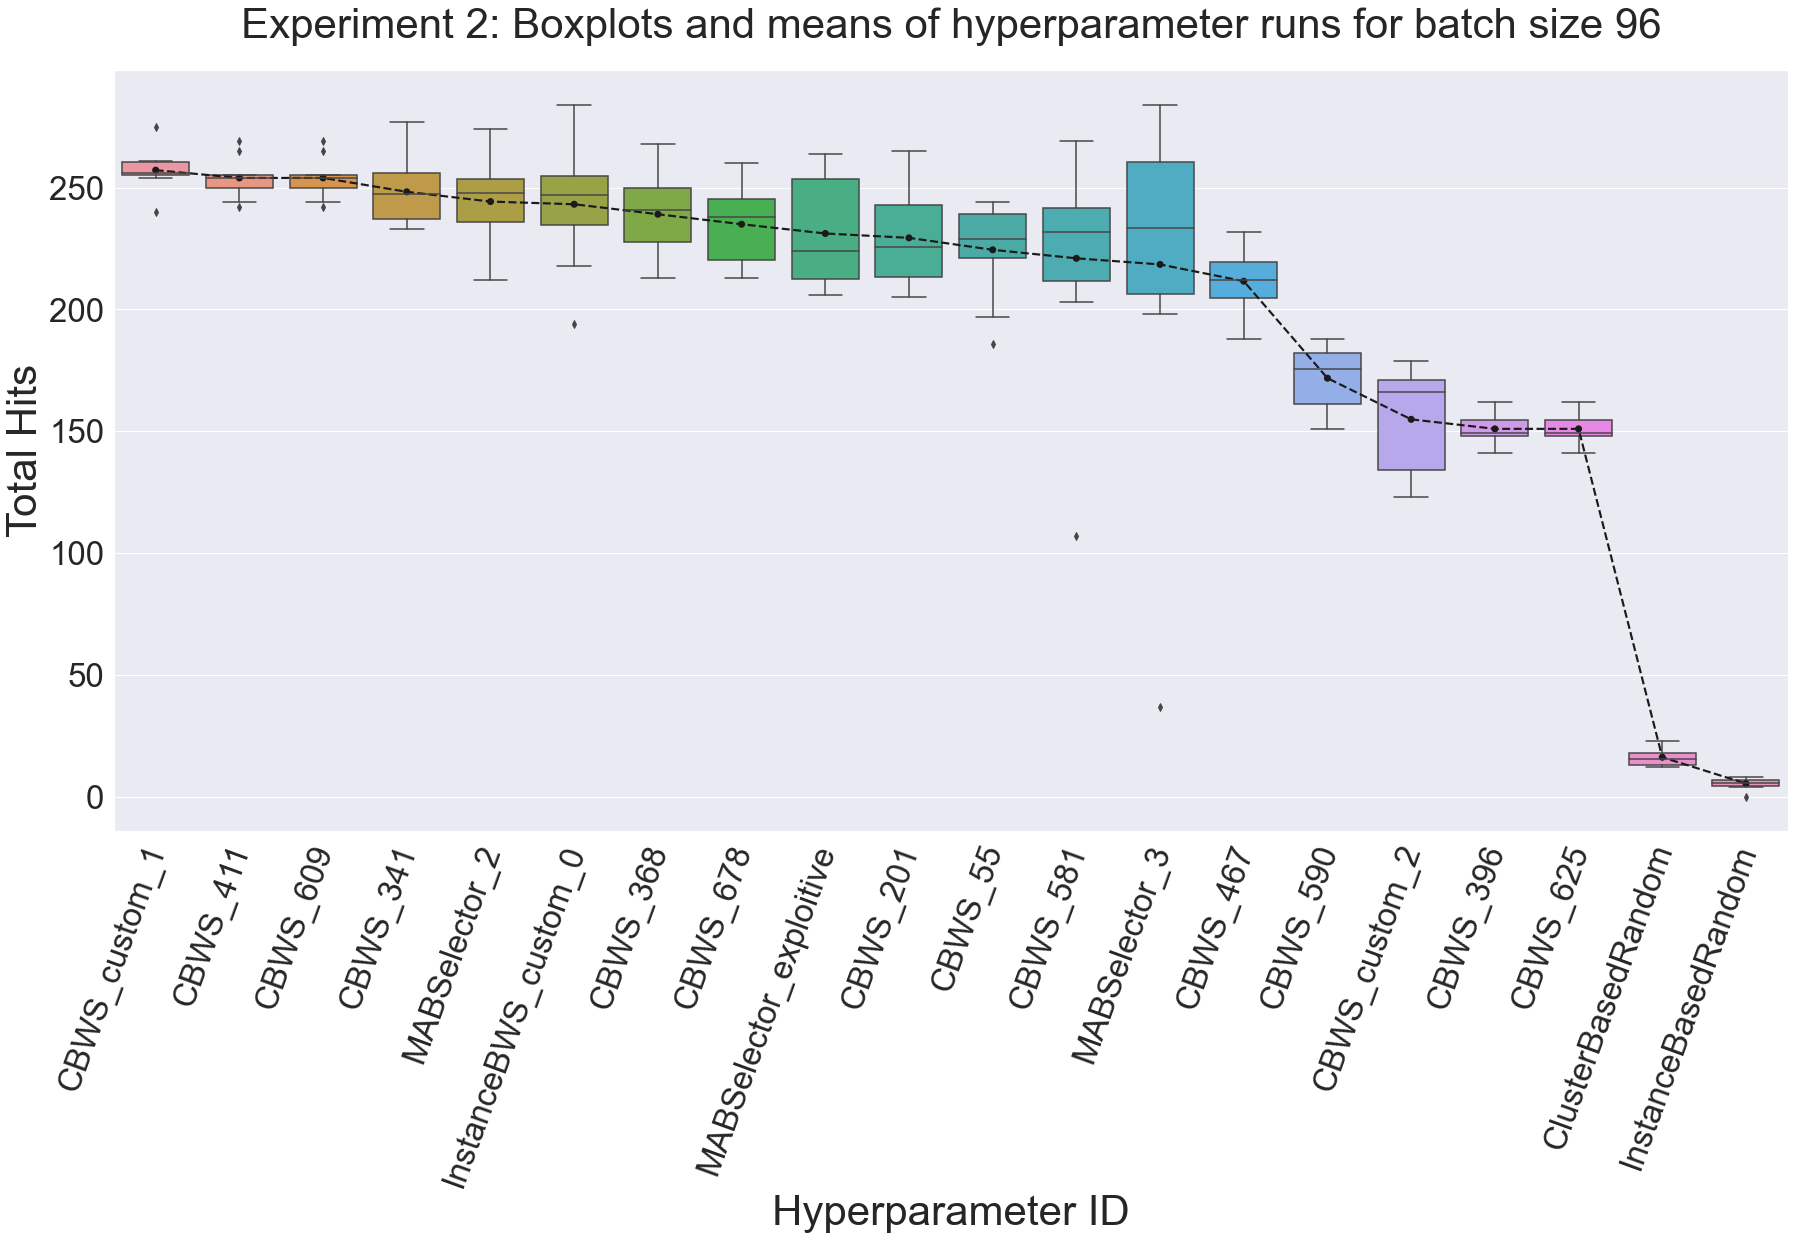

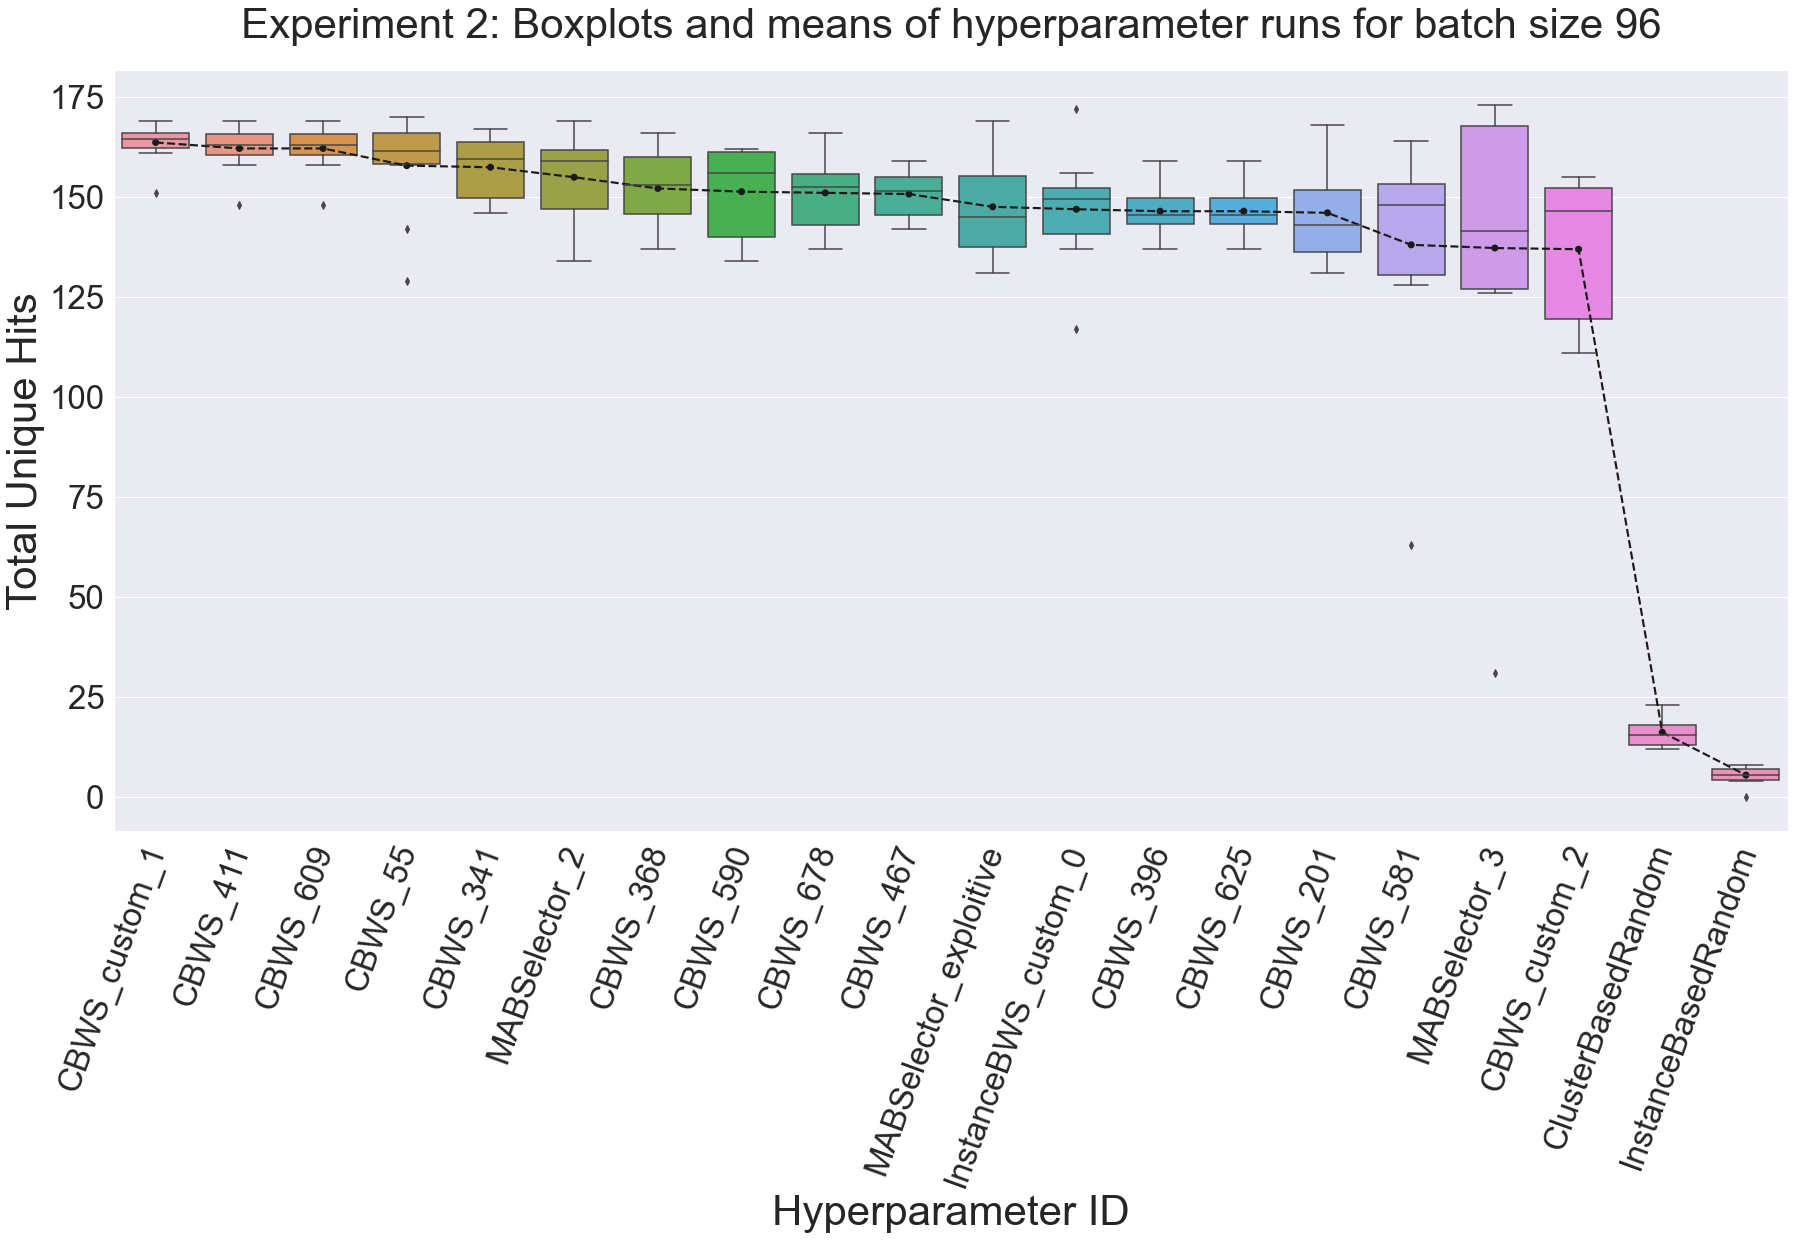

In [72]:
from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=3.0)
%load_ext autoreload
%autoreload 2

top_96_hs = get_top_summary(all_96_hs.reset_index(drop=True))
top_96_bm = get_top_summary(all_96_bm.reset_index(drop=True))
top_96_cs = get_top_summary(all_96_cs.reset_index(drop=True))

fontsize=42
all_96 = pd.concat([all_96_cs, all_96_bm, all_96_hs])
top_96_all = pd.concat([top_96_cs, top_96_bm, top_96_hs])
plot_boxplots_simple(all_96, top_96_all, metric_col_box='total_hits', metric_col_point='total_hits_mean',
                     title='Experiment 2: Boxplots and means of hyperparameter runs for batch size 96',
                     xlabel='Hyperparameter ID', ylabel='Total Hits', fontsize=fontsize)
plot_boxplots_simple(all_96, top_96_all, metric_col_box='total_unique_hits', metric_col_point='total_unique_hits_mean',
                     title='Experiment 2: Boxplots and means of hyperparameter runs for batch size 96',
                     xlabel='Hyperparameter ID', ylabel='Total Unique Hits', fontsize=fontsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open destfile 'C:\Users\Moeman\AppData\Local\Temp\Rtmpe0ARCk\filee66c1089337c', reason 'No such file or directory'); using local file 'C:/Users/Moeman/Anaconda3/envs/thesis/Lib/R/doc/CRAN_mirrors.csv'



Total Hits Corrected Friedman's chi-squared statistic: 18.667269439421332. DoF: 17.0. p-value: 0.0.


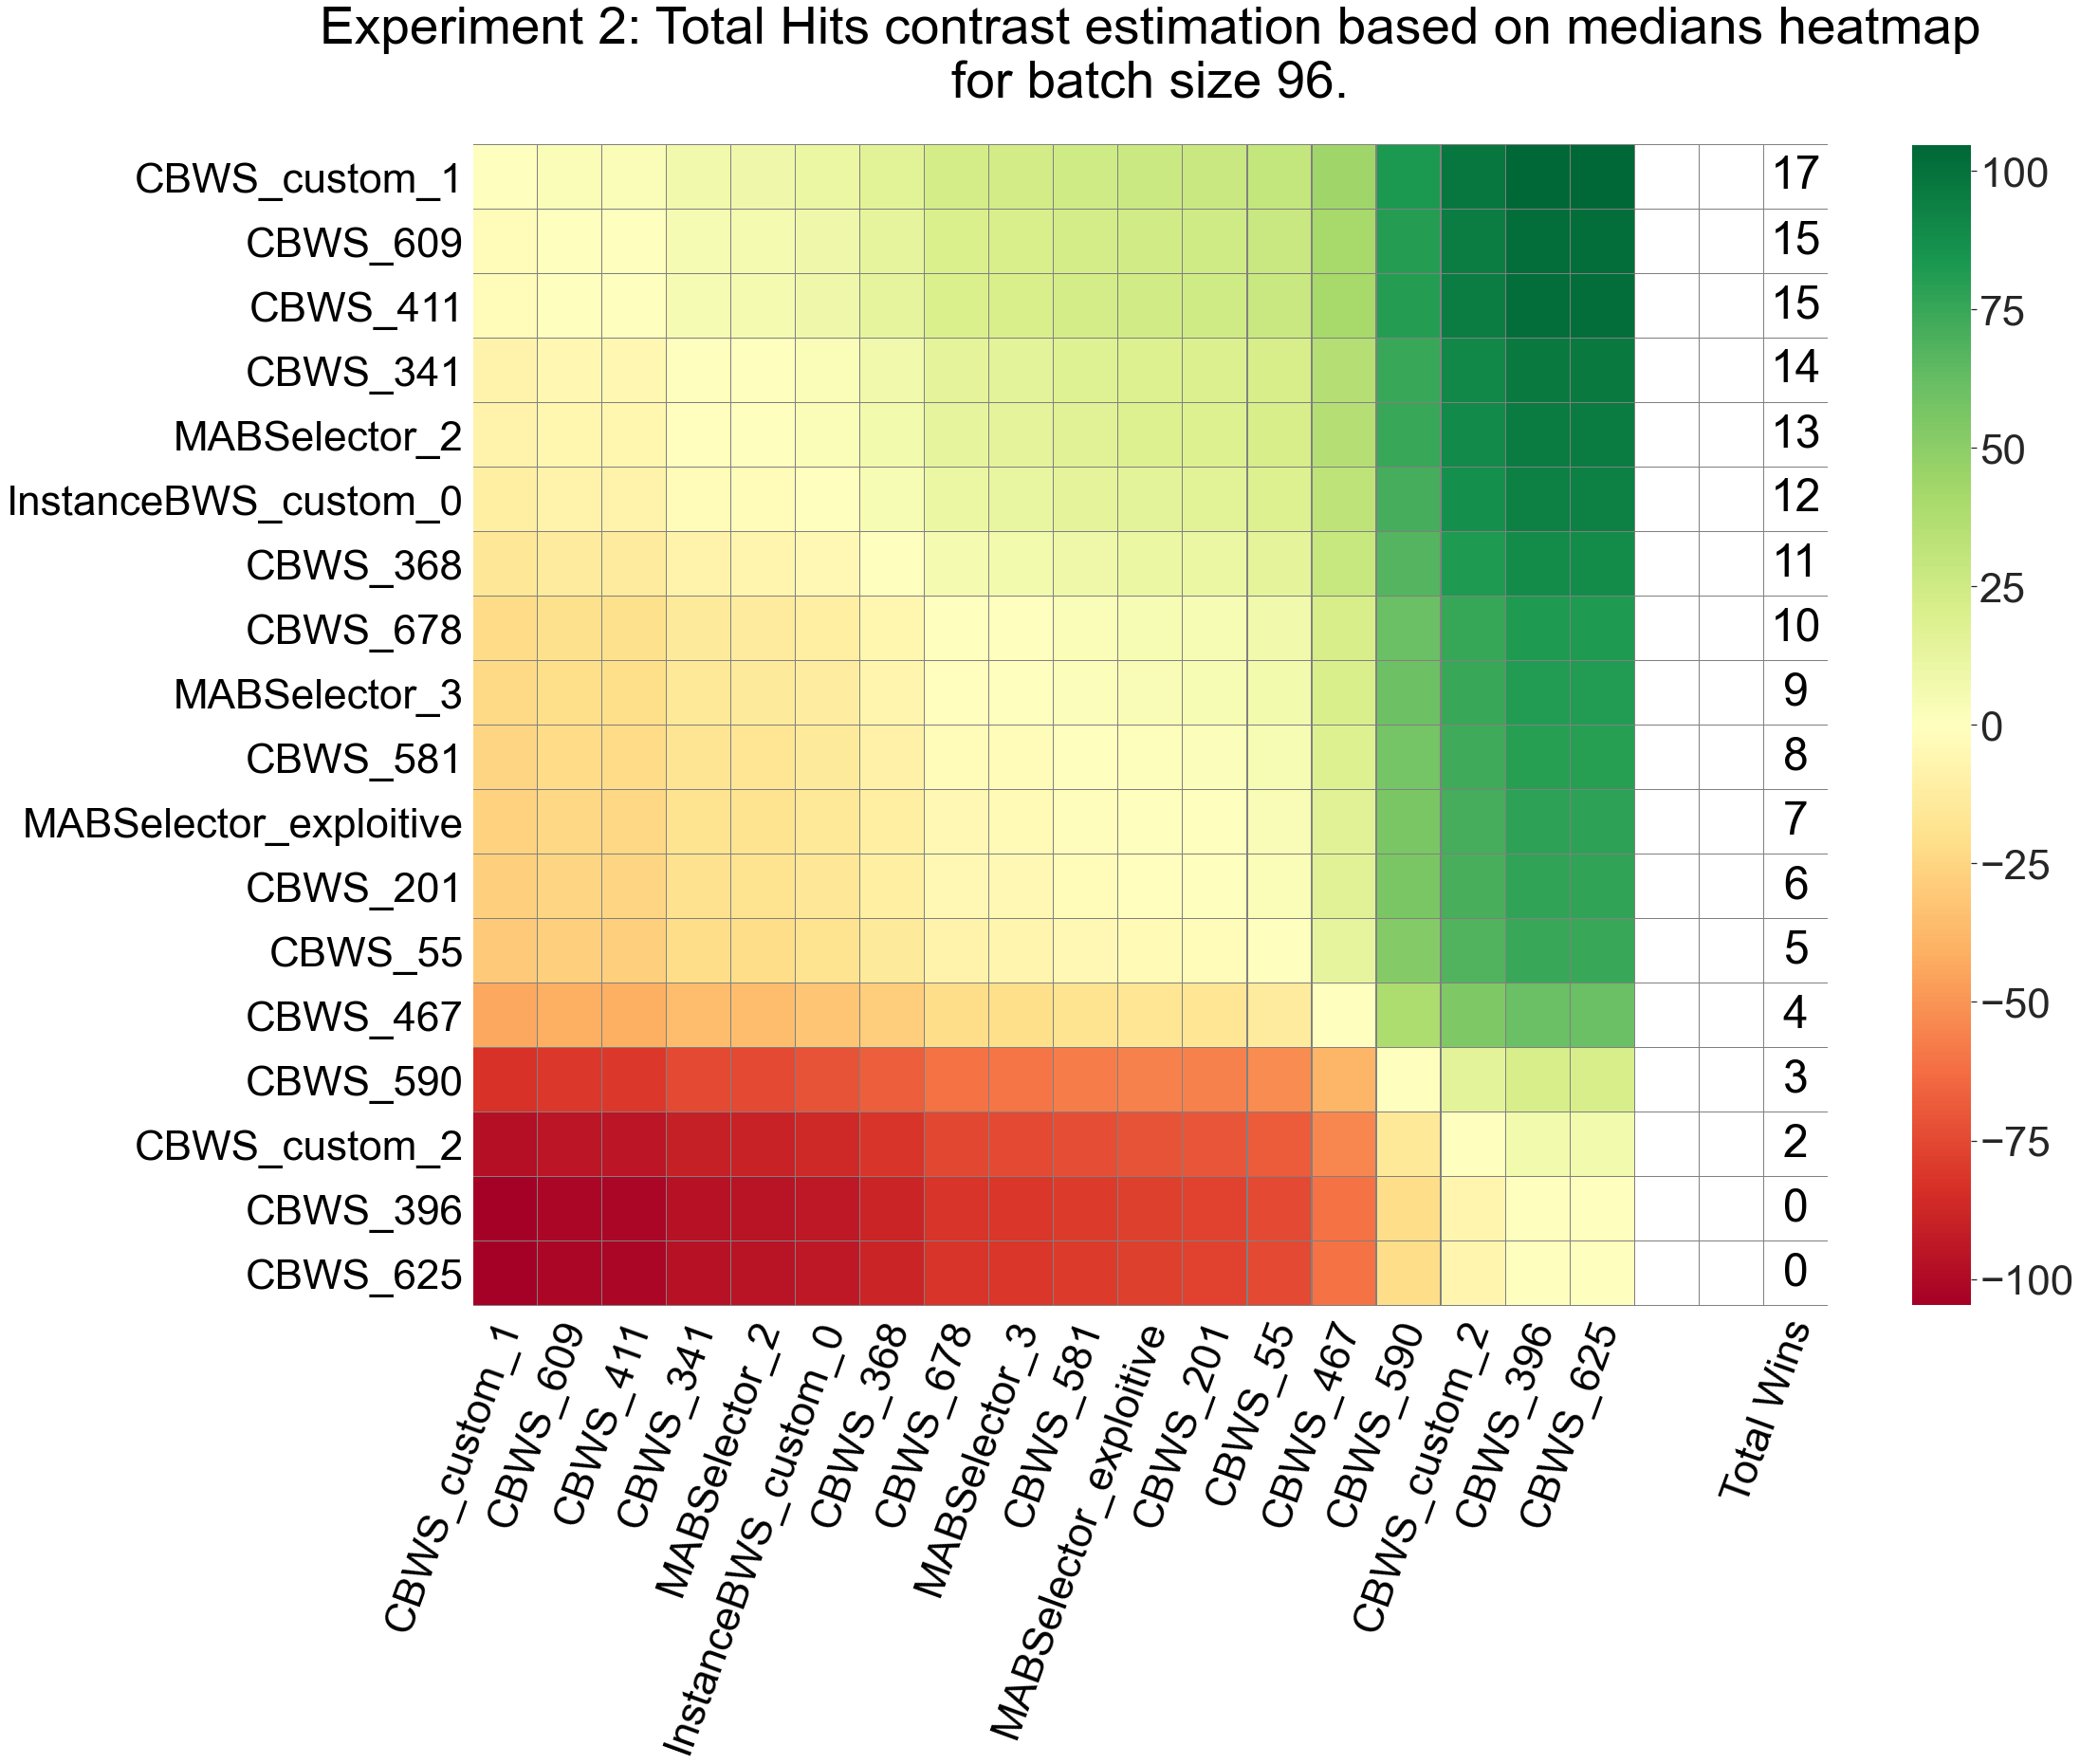

R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open destfile 'C:\Users\Moeman\AppData\Local\Temp\Rtmpe0ARCk\filee66c44a95e7', reason 'No such file or directory'); using local file 'C:/Users/Moeman/Anaconda3/envs/thesis/Lib/R/doc/CRAN_mirrors.csv'



Total Unique Hits Corrected Friedman's chi-squared statistic: 3.7418035182046623. DoF: 17.0. p-value: 5.289329725655101e-06.


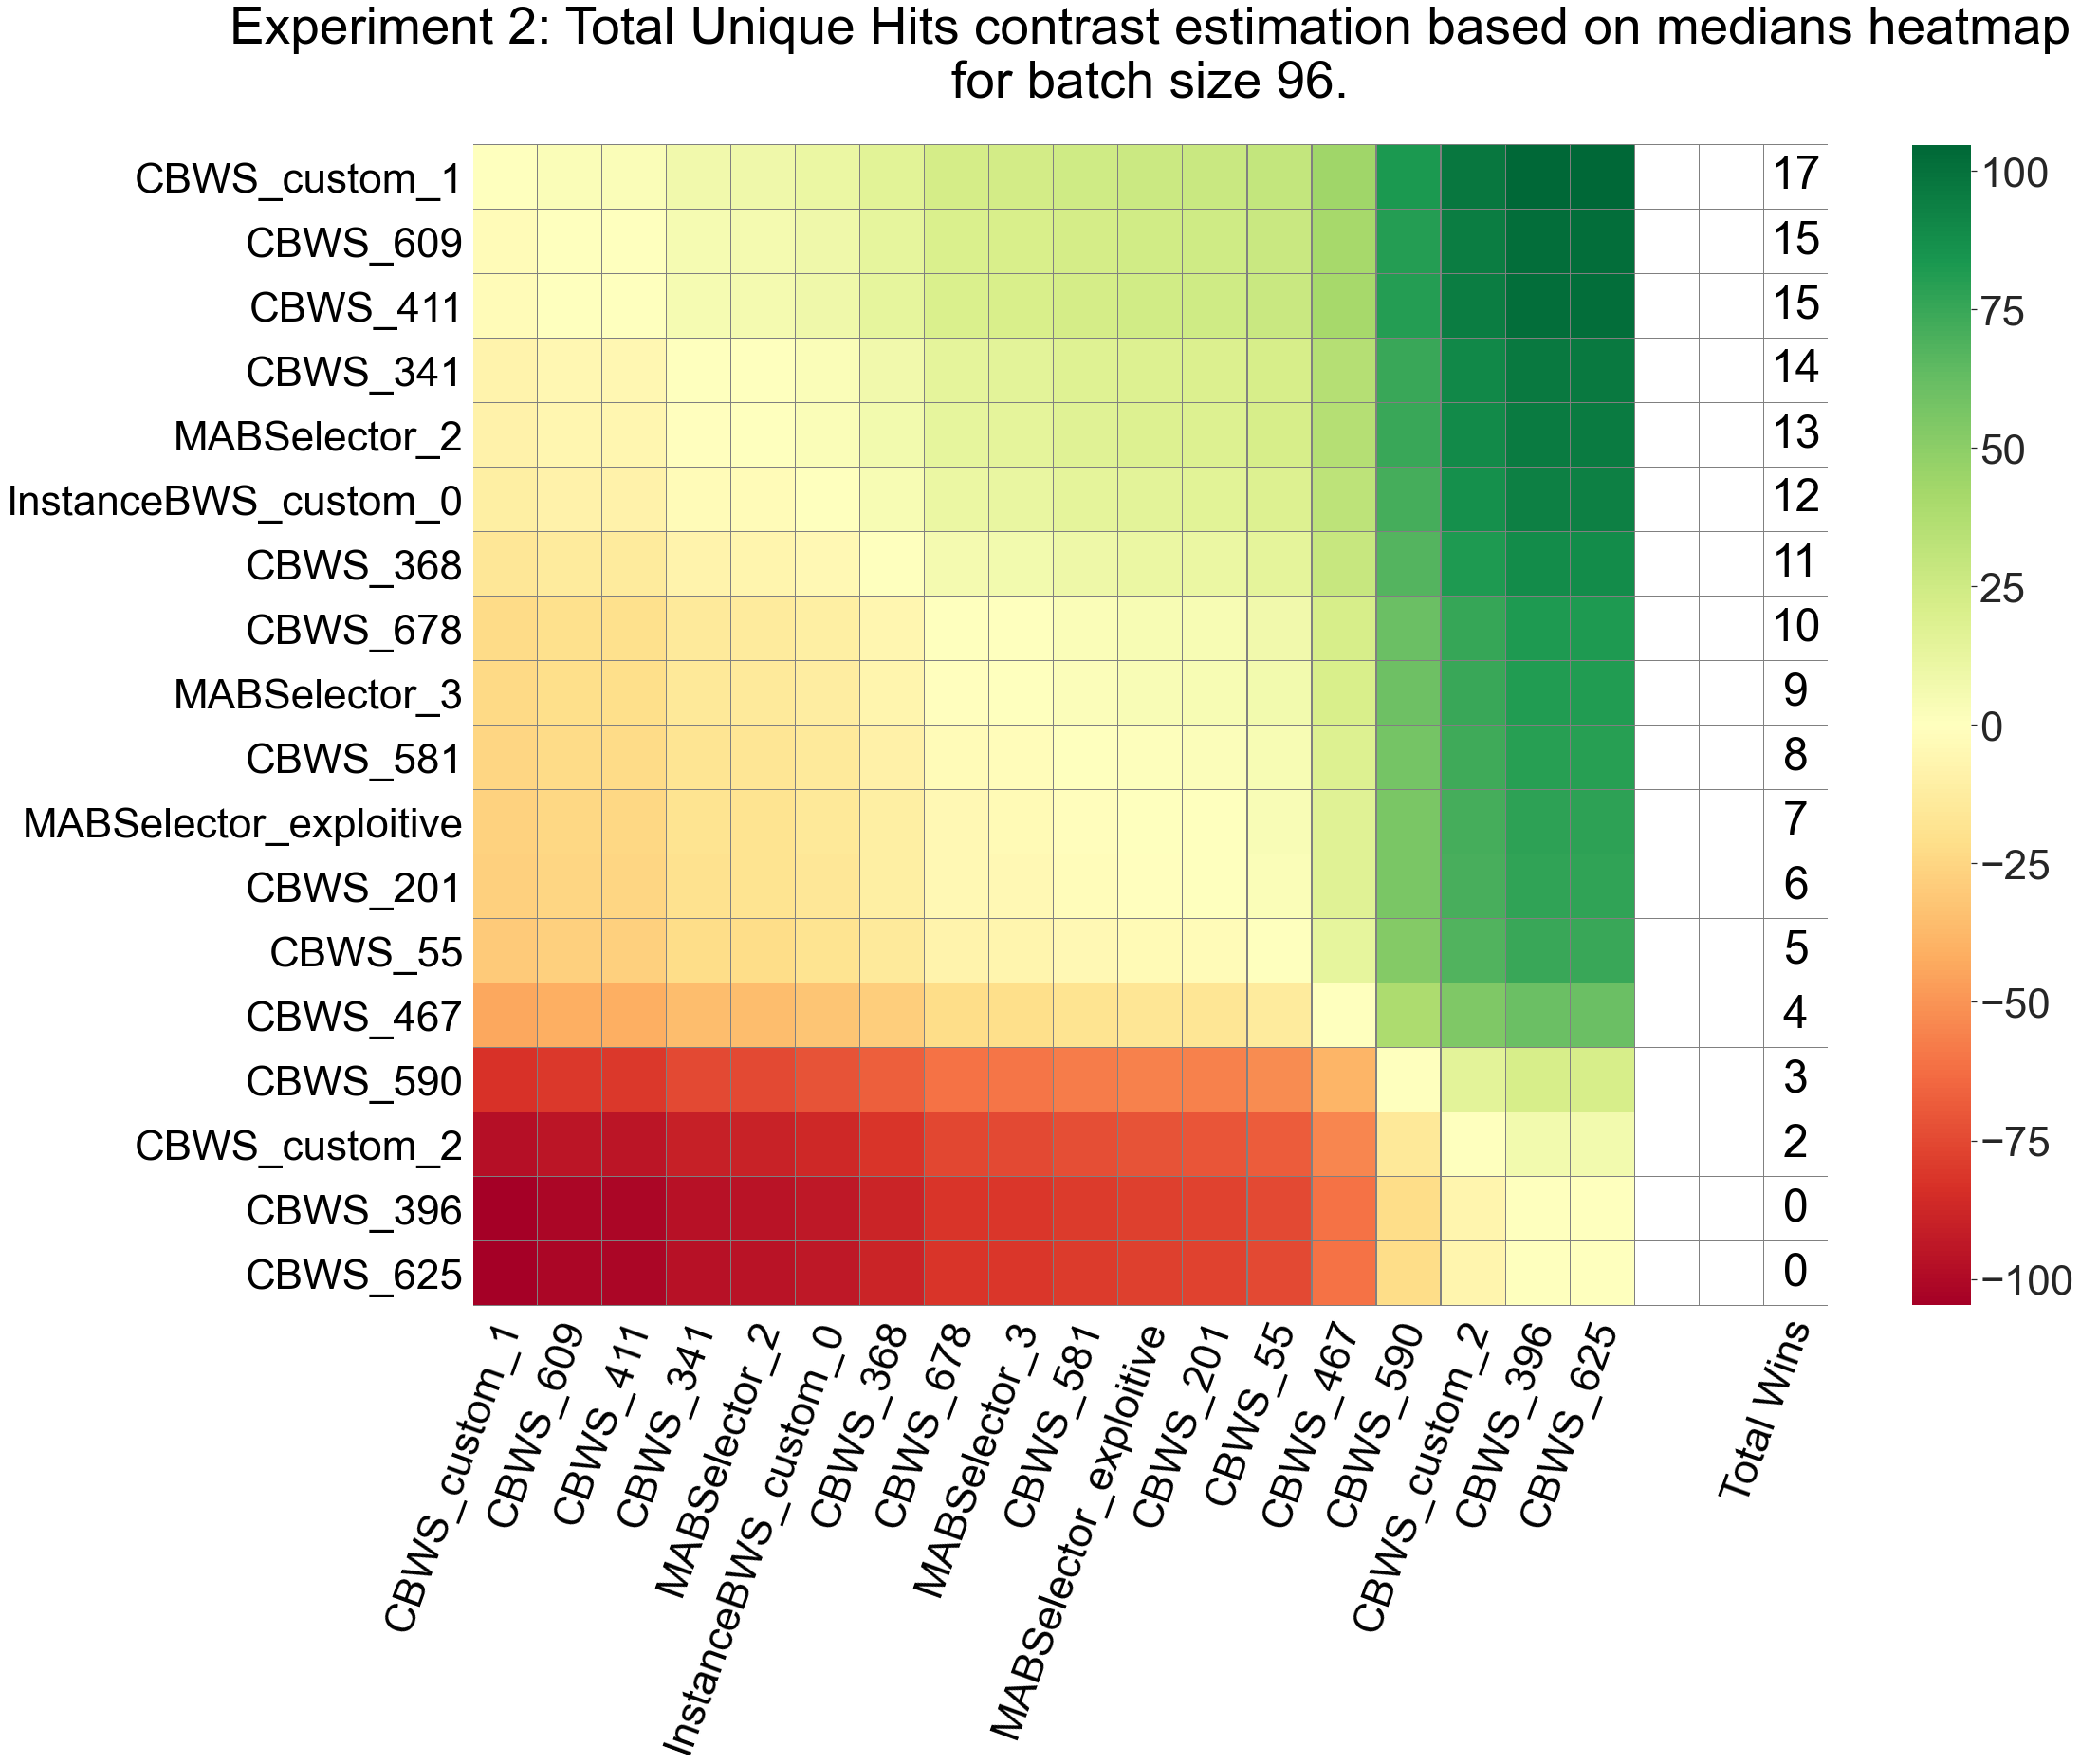

In [77]:
from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=4)
%load_ext autoreload
%autoreload 2

total_96_cs = all_96_cs[all_96_cs['iter_num'] == 9999]
total_96_hs = all_96_hs[all_96_hs['iter_num'] == 9999]
total_96_bm = all_96_bm[all_96_bm['iter_num'] == 9999]

fontsize=55
metric='total_hits'
topk=18
corr_friedman_chisq, df1, pval = get_friedman_test(total_96_cs, total_96_bm, total_96_hs, metric, topk=topk)
print('Total Hits Corrected Friedman\'s chi-squared statistic: {}. DoF: {}. p-value: {}.'.format(corr_friedman_chisq, df1, pval))
cem_hits_96_df, cem_wins_hits_96_df  = plot_cem_heatmap(total_96_cs, total_96_bm, total_96_hs, figsize=(30, 30),
                          title='Experiment 2: Total Hits contrast estimation based on medians heatmap\nfor batch size 96.',
                          metric=metric, topk=topk, use_custom_cem=True, fontsize=fontsize)
metric='total_unique_hits'
topk=18
corr_friedman_chisq, df1, pval = get_friedman_test(total_96_cs, total_96_bm, total_96_hs, metric, topk=topk)
print('Total Unique Hits Corrected Friedman\'s chi-squared statistic: {}. DoF: {}. p-value: {}.'.format(corr_friedman_chisq, df1, pval))
cem_uhits_96_df, cem_wins_uhits_96_df = plot_cem_heatmap(total_96_cs, total_96_bm, total_96_hs, figsize=(30, 30),
                              title='Experiment 2: Total Unique Hits contrast estimation based on medians heatmap\nfor batch size 96.',
                                      metric=metric, topk=topk, use_custom_cem=True, fontsize=fontsize)

Promoting to experiment 3 from each group (Custom CBWS, Sampled CBWS, Benchmarks) based on mean total hits, mean unique hits, and standard deviation:
* **Custom CBWS** : **CBWS_custom_1** promoted to experiment 3. Has most mean total hits and unique hits. Lowest standard deviation as well.

* **Sampled CBWS** : **CBWS_609** (removed 411 due to large similarity in param configs; essentially picking the same cpds), **CBWS_55** (2nd highest Sampled CBWS mean total unique hits), **CBWS_341** (2nd best Sampled CBWS mean total hits and 3rd mean total unique hits).

* **Benchmarks** : **ClusterBasedRandom** and **InstanceBasedRandom** for comparison (and it's fast to run), **MABSelector_2** (high performing on both metrics), **MABSelector_exploitive** for comparison to a simple exploitive strategy.

Promoted strategy list: [CBWS_custom_1, CBWS_609, CBWS_55, CBWS_341, ClusterBasedRandom, InstanceBasedRandom, MABSelector_2, MABSelector_exploitive]

Total strategies: 8

---
# Plot exploit-explore hit progress

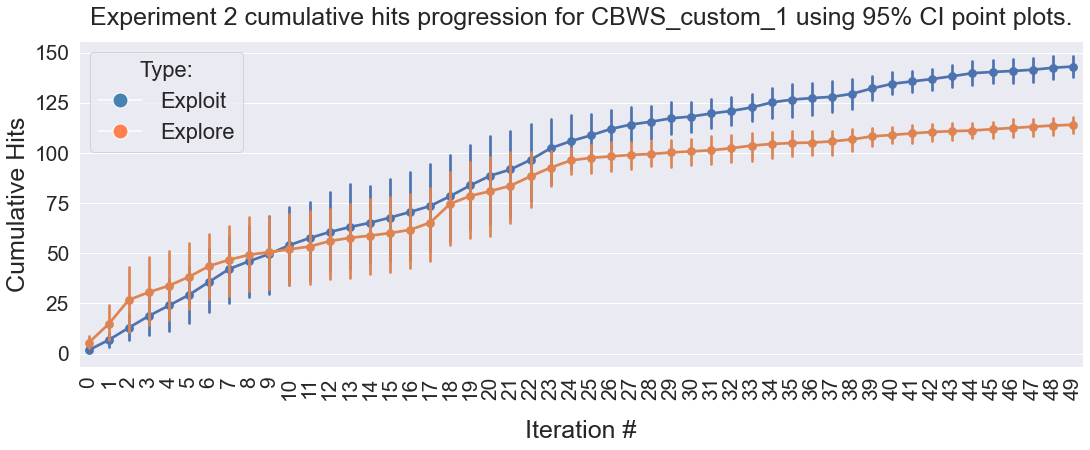

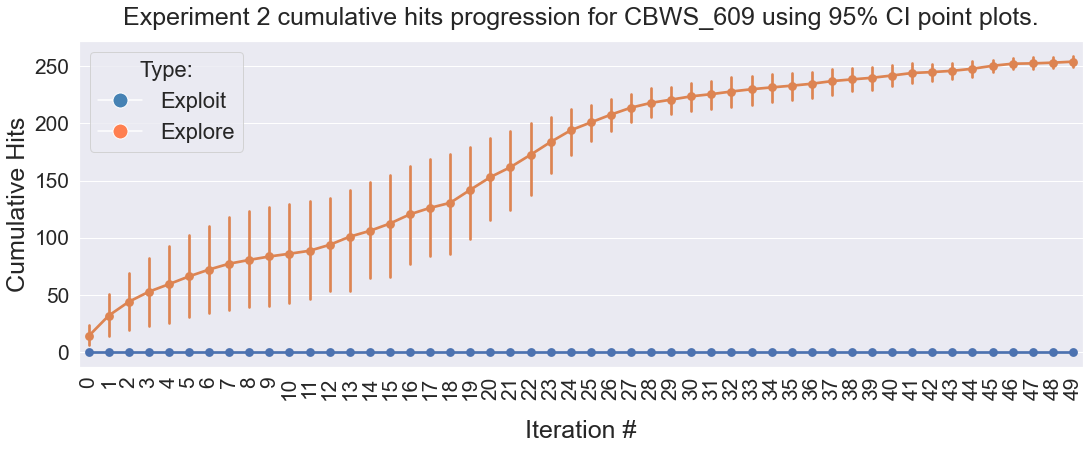

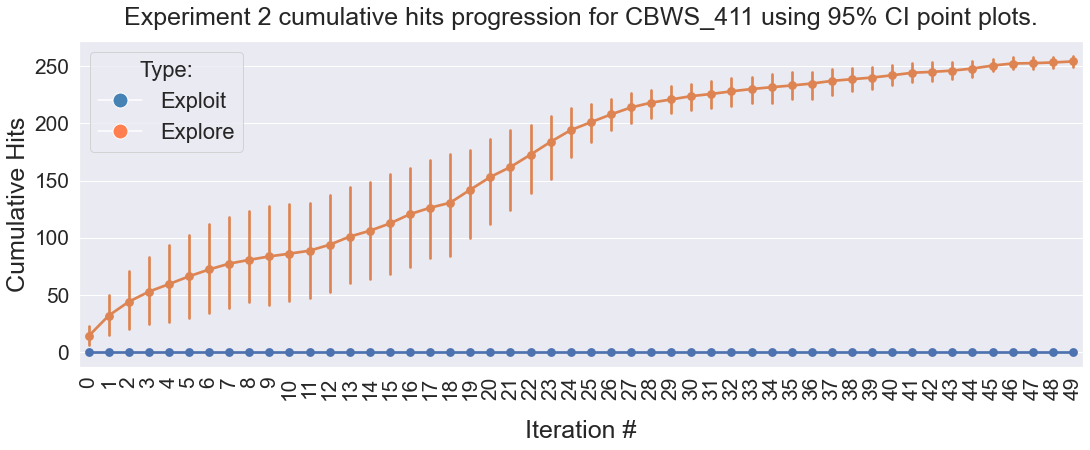

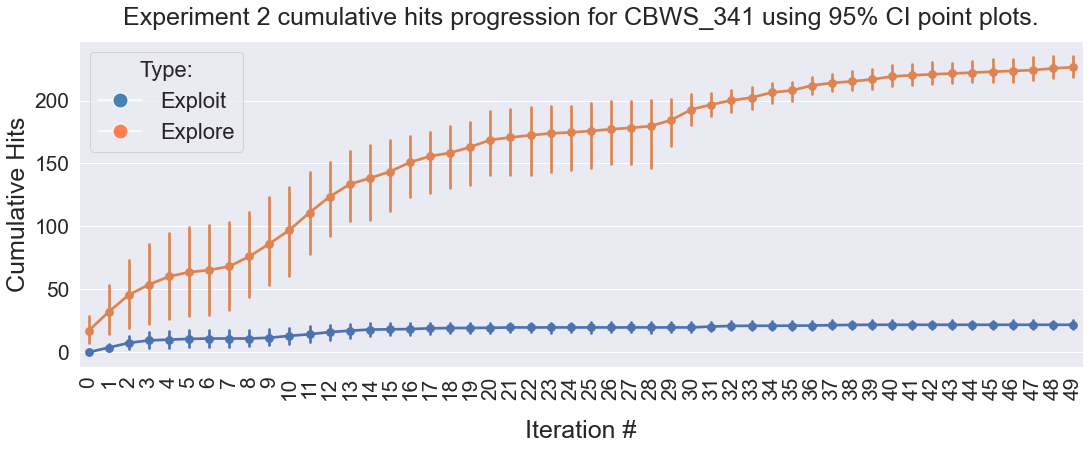

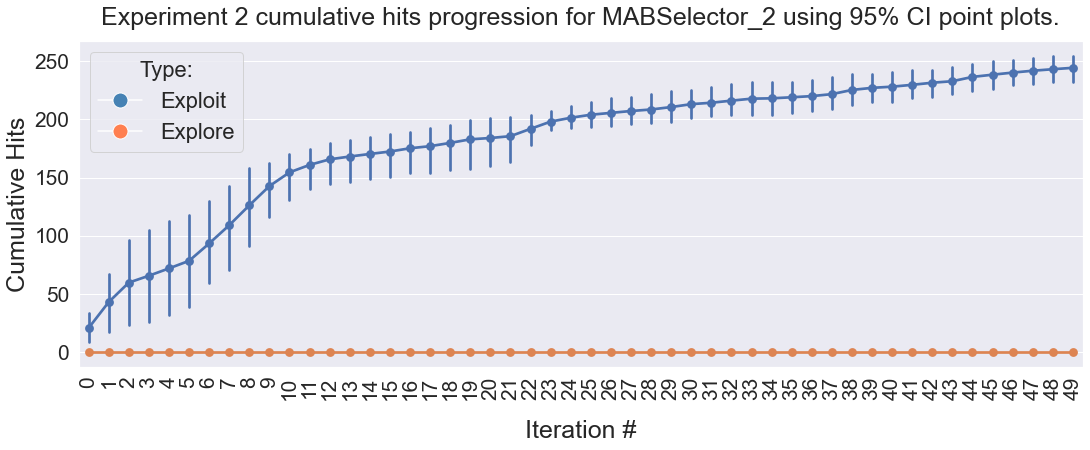

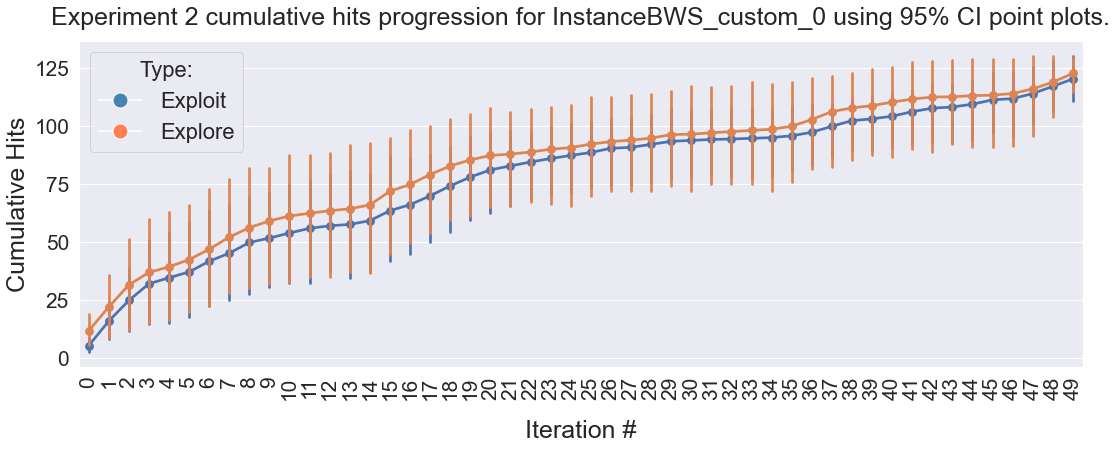

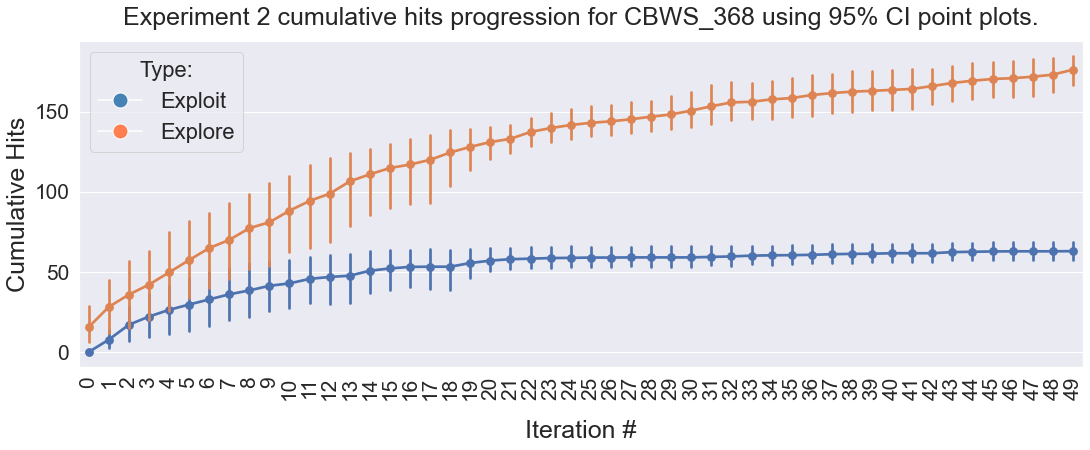

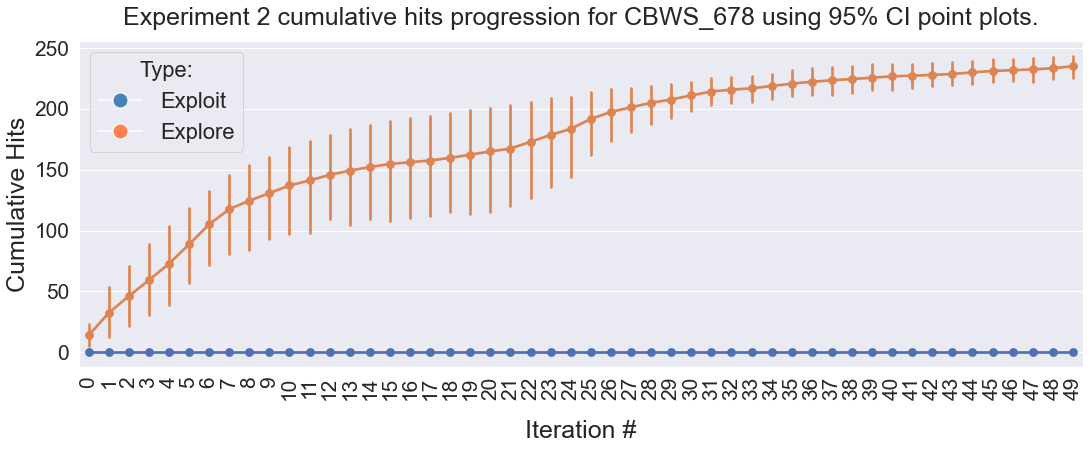

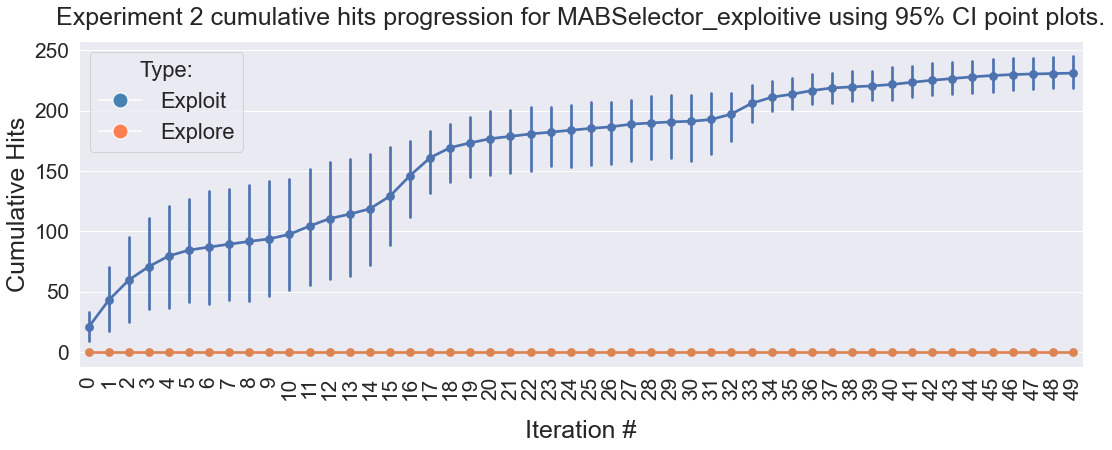

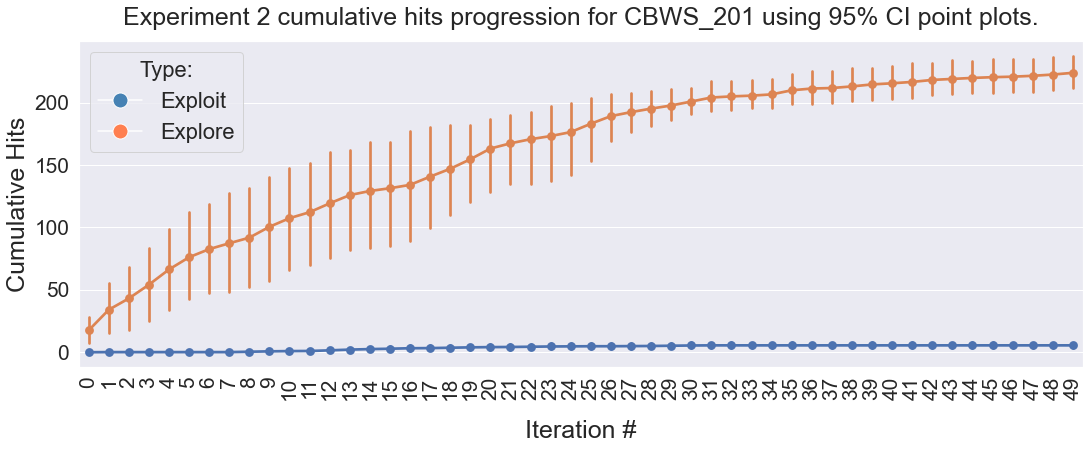

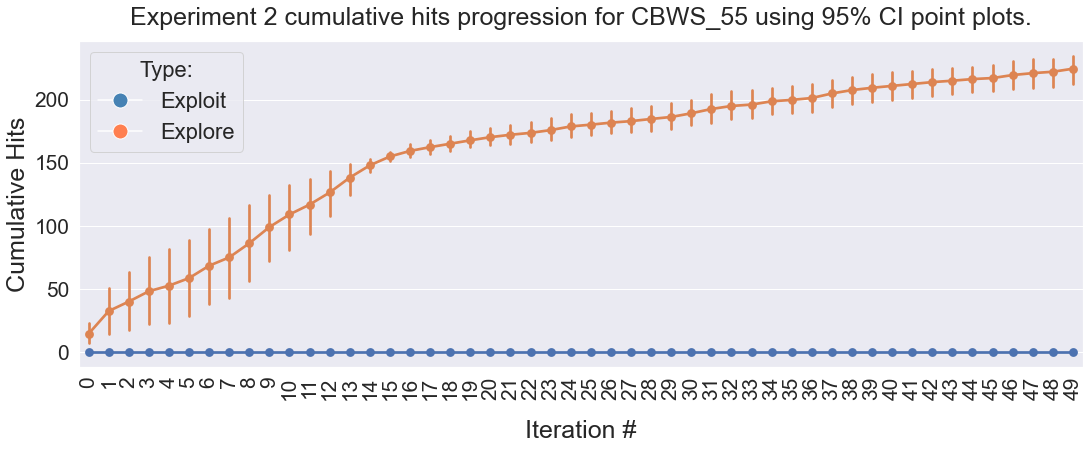

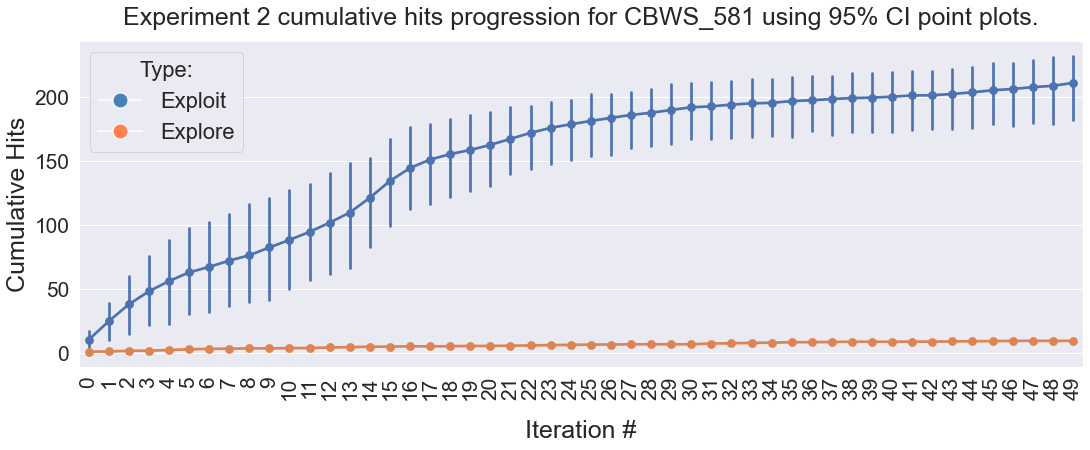

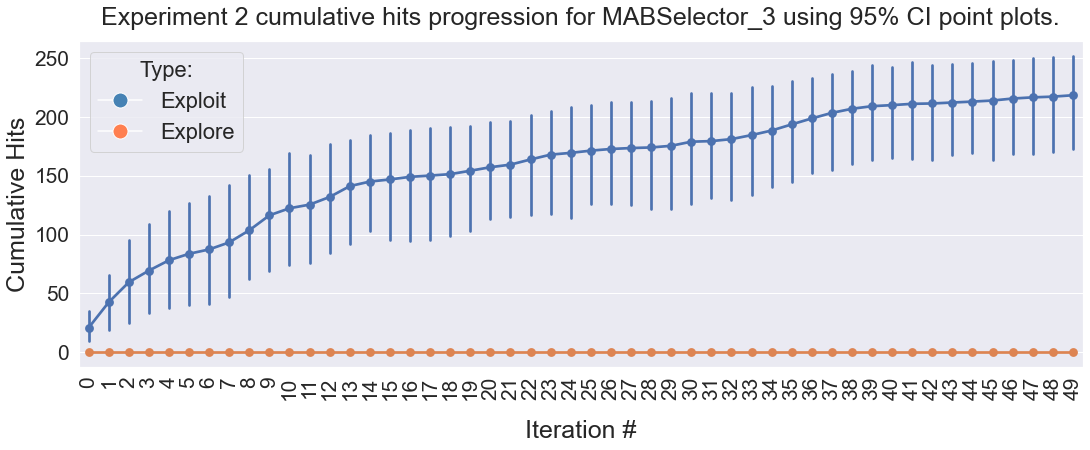

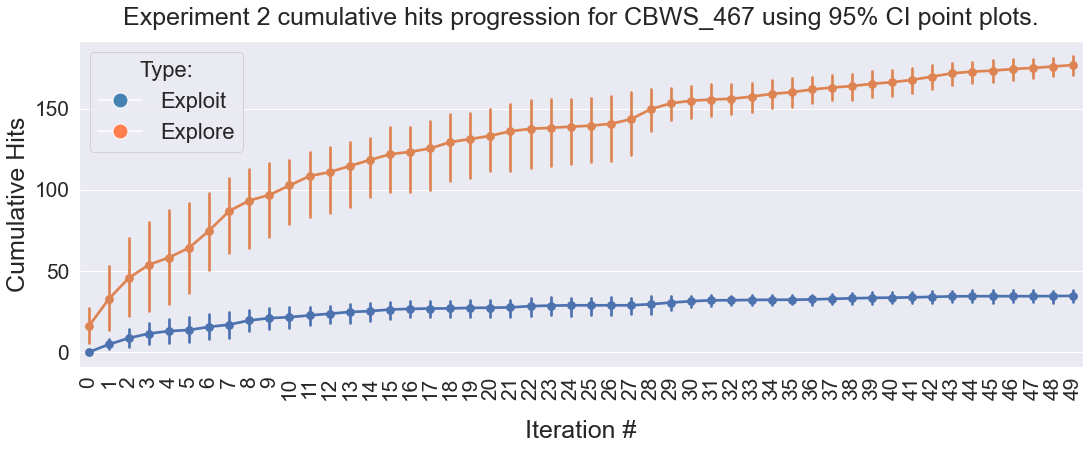

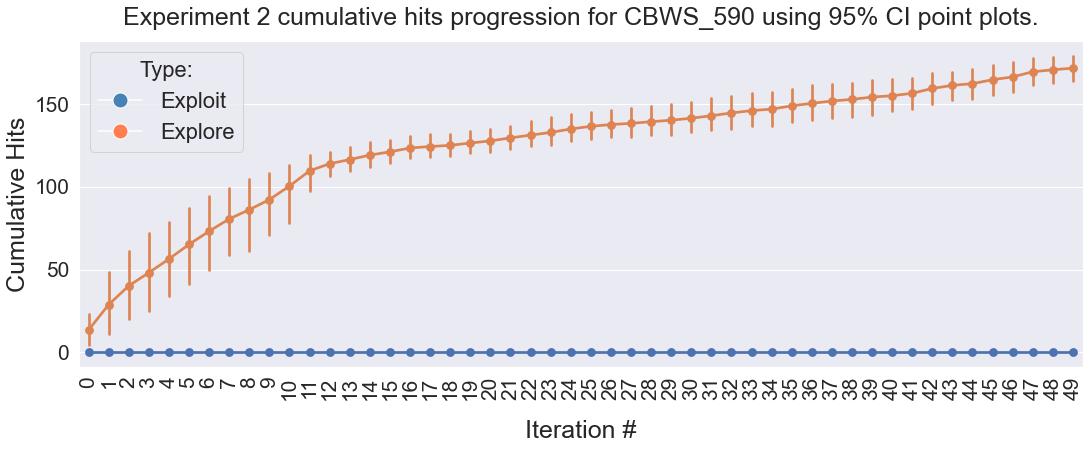

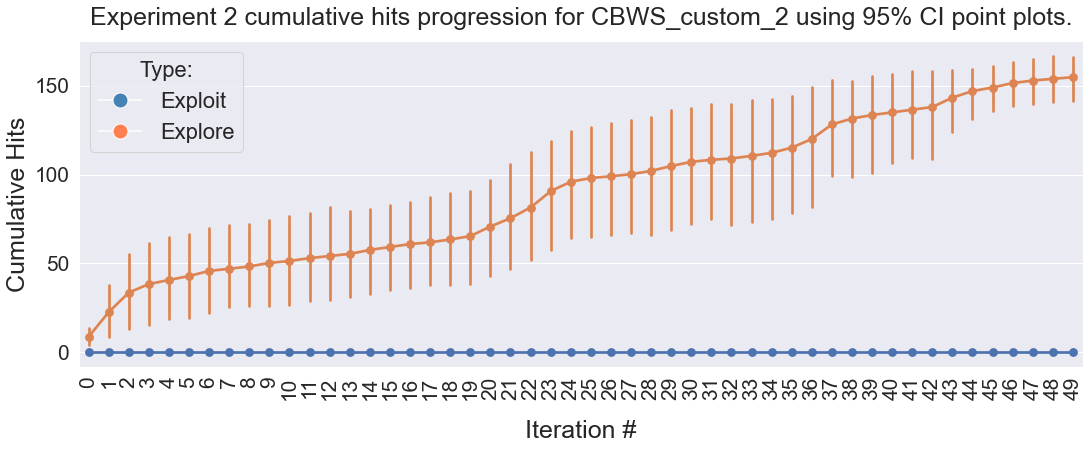

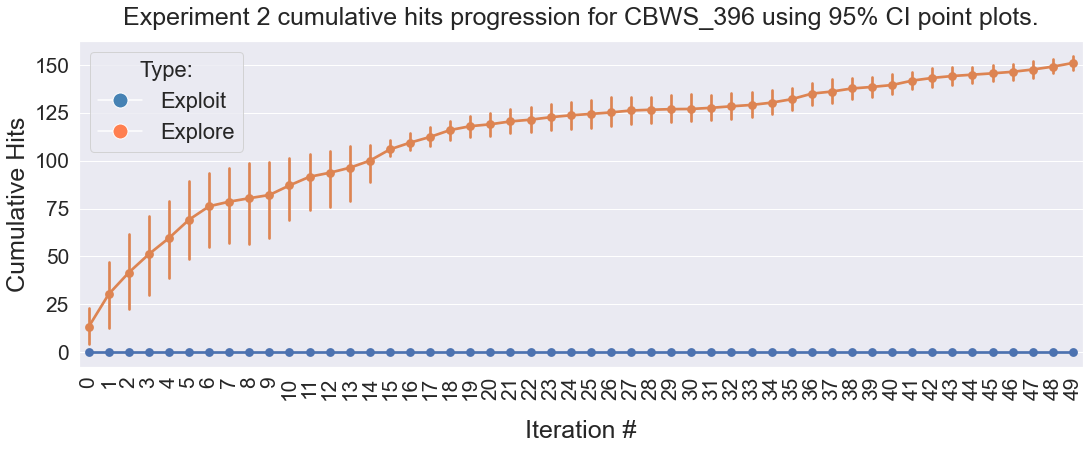

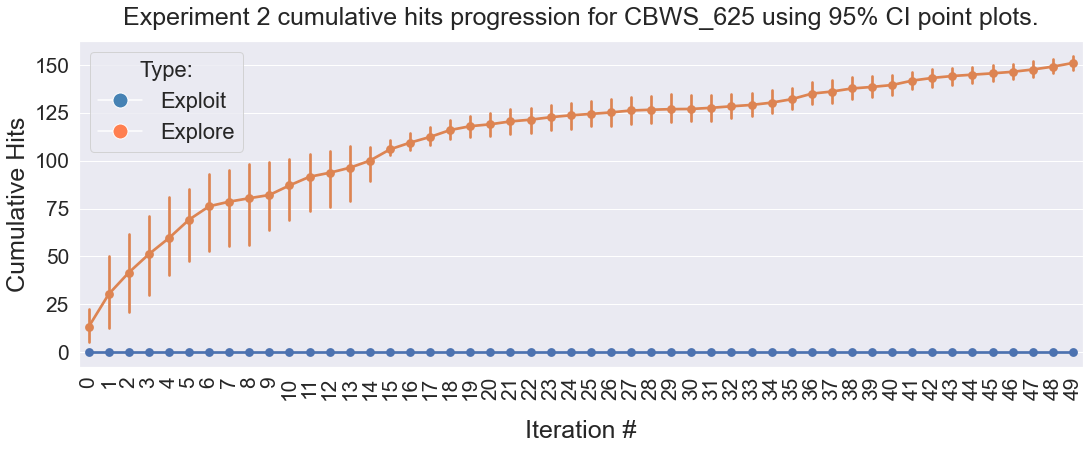

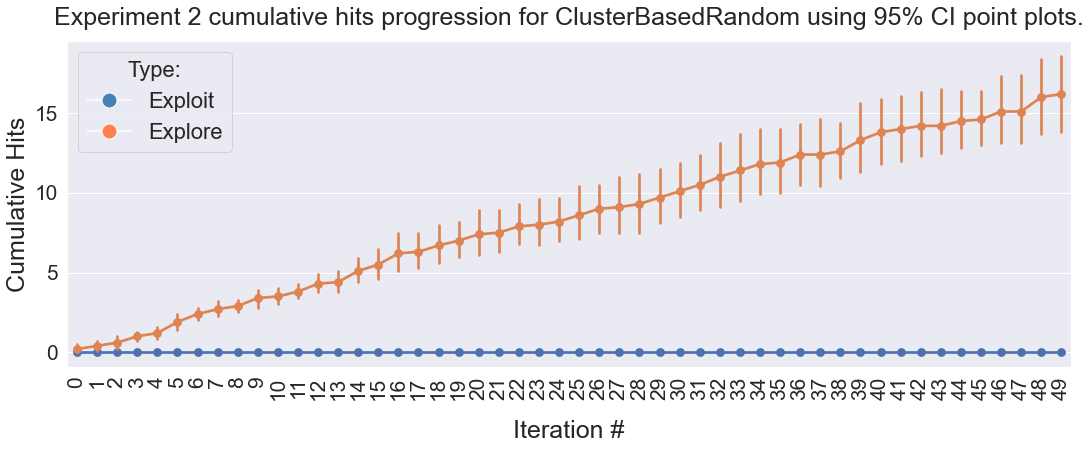

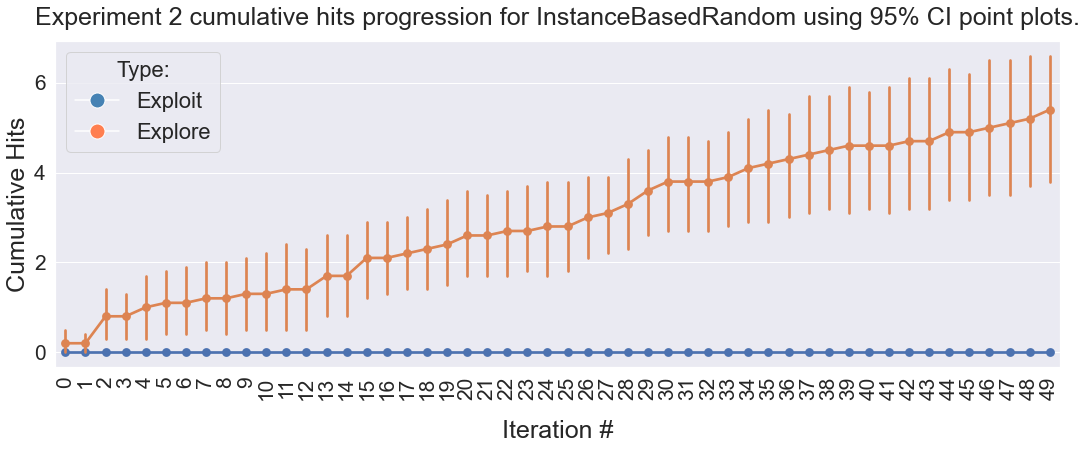

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.9)
figsize=(18, 6)

plot_max_min_runs = False
sorted_hid_list = sdf.index.tolist()
iter_df = cdf[cdf['iter_num'] != 9999]
for hid in sorted_hid_list:
    temp_df = iter_df[iter_df['hs_id'] == hid]
    run_list = []
    for rid in temp_df['rf_id'].unique():
        run_df = temp_df[temp_df['rf_id'] == rid].sort_values('iter_num')
        run_df['exploit_cumsum'] = run_df['exploitation_hits'].cumsum()
        run_df['explore_cumsum'] = run_df['exploration_hits'].cumsum()

        run_list.append(run_df)

    run_df = pd.concat(run_list)

    run_df_exploit, run_df_explore = run_df.copy(), run_df.copy()
    run_df_exploit['Cumulative Hits'] = run_df_exploit["exploit_cumsum"]
    run_df_exploit['Type'] = 'Exploit'
    run_df_explore['Cumulative Hits'] = run_df_explore["explore_cumsum"]
    run_df_explore['Type'] = 'Explore'
    run_df = pd.concat([run_df_exploit, run_df_explore])
    
    title = 'Experiment 2 cumulative hits progression for {} using 95% CI point plots.'.format(hid.replace('ClusterBasedWCSelector', 'CBWS'))
    fig, ax = plt.subplots(figsize=figsize)
    sns.pointplot(x="iter_num", y="Cumulative Hits", hue='Type', data=run_df)
    plt.xticks(rotation=90, ha='center')
    
    fontsize=25
    plt.ylabel('Cumulative Hits', fontsize=fontsize)
    plt.xlabel('Iteration #', fontsize=fontsize, labelpad=20)
    plt.title(title, fontsize=fontsize, y=1.03)
    
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                           markerfacecolor='steelblue', markersize=15),
                    Line2D([0], [0], marker='o', color='w', label='Scatter',
                           markerfacecolor='coral', markersize=15)]
        
    ax.legend(custom_lines, ['Exploit', 'Explore'],
              title='Type:', title_fontsize=22, fontsize=22)
    
    plt.savefig('./exp2/hp_{}.png'.format(hid.replace('ClusterBasedWCSelector', 'CBWS')), bbox_inches='tight');
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.3)
figsize=(14, 6)

plot_max_min_runs = False
sorted_hid_list = sdf.index.tolist()
iter_df = cdf[cdf['iter_num'] != 9999]
for hid in sorted_hid_list:
    temp_df = iter_df[iter_df['hs_id'] == hid]
    run_list = []
    for rid in temp_df['rf_id'].unique():
        run_df = temp_df[temp_df['rf_id'] == rid].sort_values('iter_num')
        run_df['exploit_cumsum'] = run_df['exploitation_hits'].cumsum()
        run_df['explore_cumsum'] = run_df['exploration_hits'].cumsum()

        run_list.append(run_df)

    run_df = pd.concat(run_list)

    plt.figure(figsize=figsize)
    
    # exploitation
    sns.boxplot(data=run_df, x='iter_num', y='exploit_cumsum', palette=sns.color_palette("Purples"), boxprops=dict(alpha=1.0))
    sns.pointplot(data=run_df, x='iter_num', y='exploit_cumsum',  
                  linestyles='--', scale=0.8, color='b', errwidth=0, capsize=0)
    
    # exploration
    sns.boxplot(data=run_df, x='iter_num', y='explore_cumsum', palette=sns.color_palette("Greens"), boxprops=dict(alpha=.5))
    sns.pointplot(data=run_df, x='iter_num', y='explore_cumsum',  
                  linestyles='--', scale=0.8, color='r', errwidth=0, capsize=0)
    
    if plot_max_min_runs:
        # min-max exploitation
        x = run_df[run_df['iter_num'] == 49]
        max_hits = x.iloc[np.argmax(x['total_hits'].values),:]['rf_id']
        max_run = run_df[run_df['rf_id'] == max_hits]
        min_hits = x.iloc[np.argmin(x['total_hits'].values),:]['rf_id']
        min_run = run_df[run_df['rf_id'] == min_hits]

        sns.pointplot(data=max_run, x='iter_num', y='exploit_cumsum',  
                      linestyles='--', scale=0.8, color='b', errwidth=0, capsize=0)
        sns.pointplot(data=max_run, x='iter_num', y='exploit_cumsum',  
                      linestyles='--', scale=0.8, color='b', errwidth=0, capsize=0)

        # min-max exploration
        sns.pointplot(data=max_run, x='iter_num', y='explore_cumsum',  
                      linestyles='--', scale=0.8, color='r', errwidth=0, capsize=0)
        sns.pointplot(data=min_run, x='iter_num', y='explore_cumsum',  
                      linestyles='--', scale=0.8, color='r', errwidth=0, capsize=0)
    
    plt.xticks(rotation=50, ha='center')
    plt.xlabel('Iteration #')
    plt.ylabel('Cumulative Hits')
    plt.legend(['Exploitation', 'Exploration'])
    plt.title(hid)
    plt.show()

In [64]:
for hid in sorted_hid_list:
    print('\\begin{subfigure}{\\includegraphics[width=0.75\\linewidth]{project_al/experiments/exp2/hp_' + '{}'.format(hid)+'.png}}')
    print('\end{subfigure}')

\begin{subfigure}{\includegraphics[width=0.75\linewidth]{project_al/experiments/exp2/hp_CBWS_custom_1.png}}
\end{subfigure}
\begin{subfigure}{\includegraphics[width=0.75\linewidth]{project_al/experiments/exp2/hp_CBWS_609.png}}
\end{subfigure}
\begin{subfigure}{\includegraphics[width=0.75\linewidth]{project_al/experiments/exp2/hp_CBWS_411.png}}
\end{subfigure}
\begin{subfigure}{\includegraphics[width=0.75\linewidth]{project_al/experiments/exp2/hp_CBWS_341.png}}
\end{subfigure}
\begin{subfigure}{\includegraphics[width=0.75\linewidth]{project_al/experiments/exp2/hp_MABSelector_2.png}}
\end{subfigure}
\begin{subfigure}{\includegraphics[width=0.75\linewidth]{project_al/experiments/exp2/hp_InstanceBWS_custom_0.png}}
\end{subfigure}
\begin{subfigure}{\includegraphics[width=0.75\linewidth]{project_al/experiments/exp2/hp_CBWS_368.png}}
\end{subfigure}
\begin{subfigure}{\includegraphics[width=0.75\linewidth]{project_al/experiments/exp2/hp_CBWS_678.png}}
\end{subfigure}
\begin{subfigure}{\include